In [2]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from collections import Counter
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [3]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Motion_Light.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (39488, 6)

DATASET OVERVIEW
        date        time  motion_status light_status  label  type
0  25-Apr-19   19:41:37               0          off      1  ddos
1  25-Apr-19   19:41:42               1           on      1  ddos
2  25-Apr-19   19:41:43               0          off      1  ddos
3  25-Apr-19   19:41:48               1           on      1  ddos
4  25-Apr-19   19:41:48               0          off      1  ddos
5  25-Apr-19   19:41:53               0          off      1  ddos
6  25-Apr-19   19:41:58               1           on      1  ddos
7  25-Apr-19   19:41:59               0          off      1  ddos
8  25-Apr-19   19:42:06               0          off      1  ddos
9  25-Apr-19   19:42:11               1           on      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39488 entries, 0 to 39487
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         -------------- 


DATA EXPLORATION
Data Types:
date             object
time             object
motion_status     int64
light_status     object
label             int64
type             object
dtype: object

Unique Motion Status: [0 1]
Unique Motion Light values: [' off' ' on']
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2264
scanning       1775
xss             449
Name: count, dtype: int64


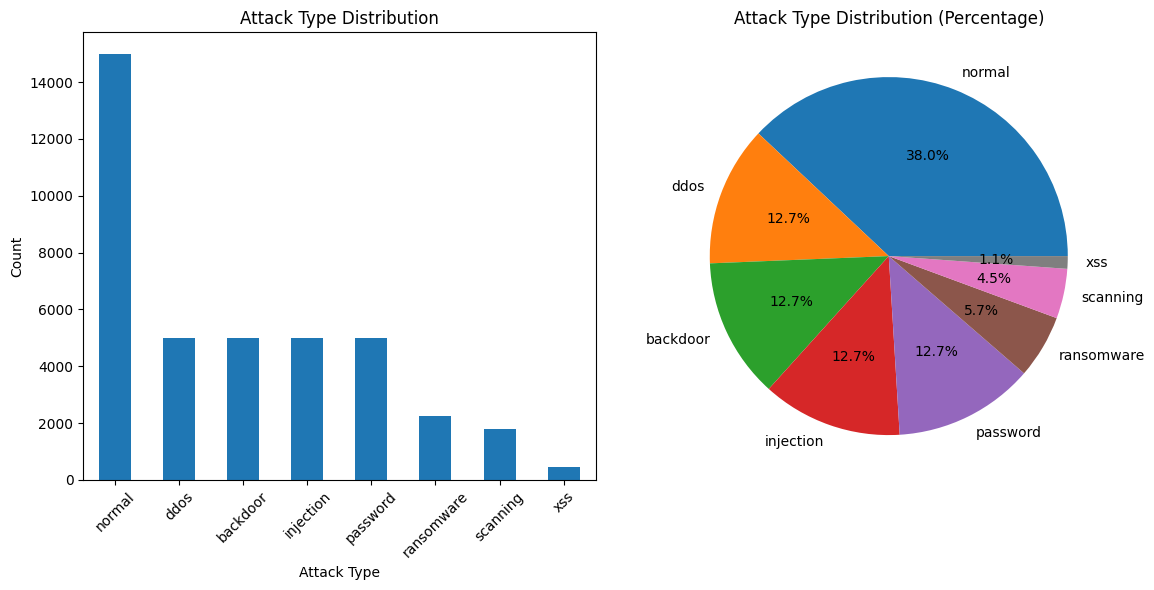

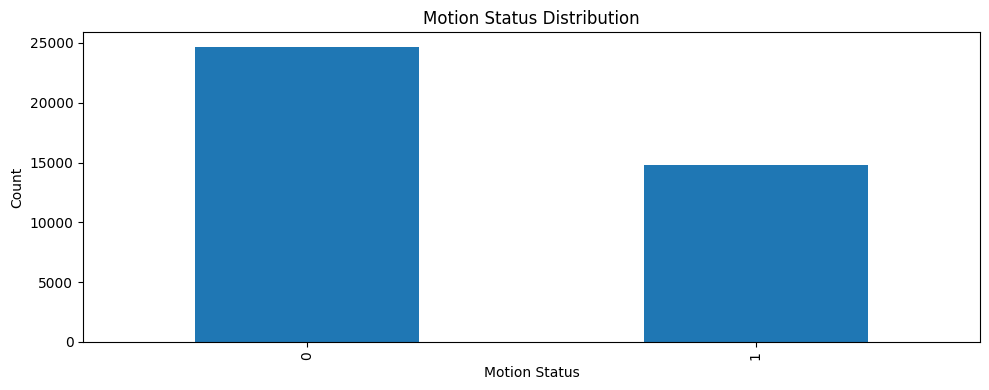

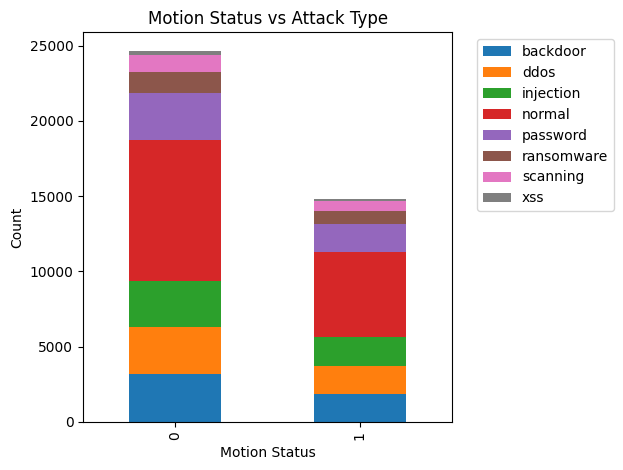

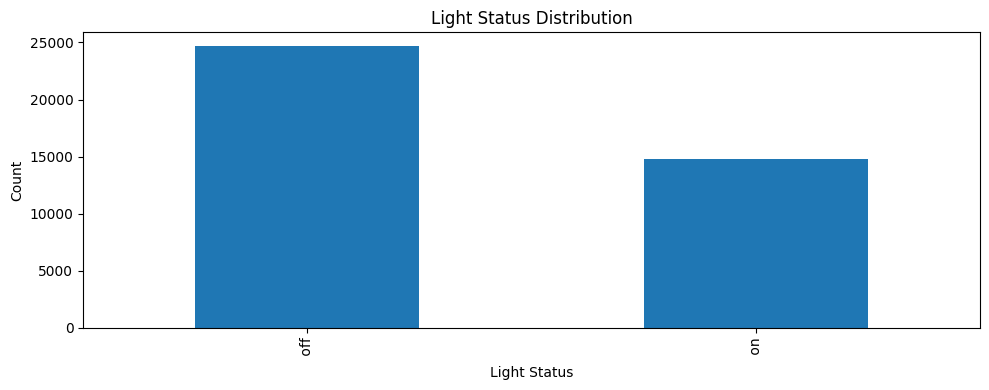

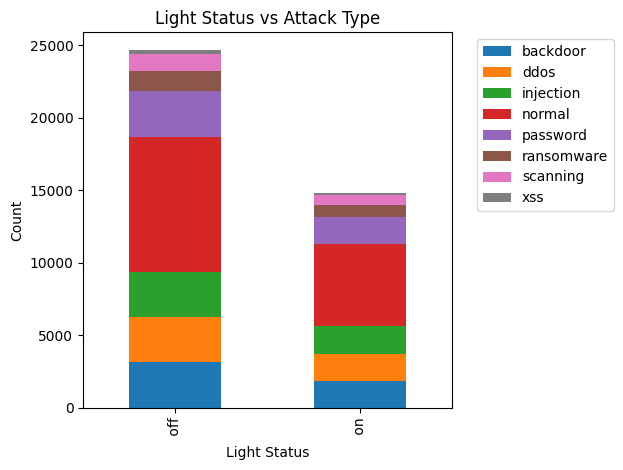

In [4]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check data types
print("Data Types:")
print(df.dtypes)

# Check unique values in categorical columns
print(f"\nUnique Motion Status: {df['motion_status'].unique()}")
print(f"Unique Motion Light values: {df['light_status'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Motion Status distribution
plt.figure(figsize=(10, 4))
df['motion_status'].value_counts().plot(kind='bar')
plt.title('Motion Status Distribution')
plt.xlabel('Motion Status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'motion_status_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['motion_status'], df['type']).plot(kind='bar', stacked=True)
plt.title('Motion Status vs Attack Type')
plt.xlabel('Motion Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'motion_status_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Light Status distribution
plt.figure(figsize=(10, 4))
df['light_status'].value_counts().plot(kind='bar')
plt.title('Light Status Distribution')
plt.xlabel('Light Status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'light_status_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['light_status'], df['type']).plot(kind='bar', stacked=True)
plt.title('Light Status vs Attack Type')
plt.xlabel('Light Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'light_status_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [5]:
df_filtered = df.copy()

In [6]:
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabungkan datetime dan urutkan
df_processed['datetime'] = pd.to_datetime(
    df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
    format='%d-%b-%y %H:%M:%S', errors='coerce'
)
df_processed = df_processed.sort_values('datetime').reset_index(drop=True)
df_processed['group_id'] = df_processed['datetime'].dt.floor('T')  # per menit

# Extract waktu
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2 * np.pi * df_processed['hour'] / 24)
df_processed['hour_cos']    = np.cos(2 * np.pi * df_processed['hour'] / 24)
df_processed['is_night']    = ((df_processed['hour'] >= 22) | (df_processed['hour'] <= 6)).astype(int)

# Encode status light
le = LabelEncoder()
df_processed['light_status_enc'] = le.fit_transform(df_processed['light_status'])

# Time diff
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# Perubahan nilai (delta)
df_processed['motion_delta'] = df_processed['motion_status'].diff().abs().fillna(0)
df_processed['light_delta']  = df_processed['light_status_enc'].diff().abs().fillna(0)

# Rolling stats
win = 10
df_processed['motion_mean_10']  = df_processed['motion_status'].rolling(window=win, min_periods=1).mean()
df_processed['motion_std_10']   = df_processed['motion_status'].rolling(window=win, min_periods=1).std().fillna(0)
df_processed['motion_sum_10']   = df_processed['motion_status'].rolling(window=win, min_periods=1).sum()
df_processed['motion_entropy']  = df_processed['motion_status'].rolling(window=win, min_periods=1).apply(
    lambda x: entropy(np.histogram(x, bins=2, density=True)[0] + 1e-6), raw=True
).fillna(0)

df_processed['light_mean_10']  = df_processed['light_status_enc'].rolling(window=win, min_periods=1).mean()
df_processed['light_std_10']   = df_processed['light_status_enc'].rolling(window=win, min_periods=1).std().fillna(0)
df_processed['light_sum_10']   = df_processed['light_status_enc'].rolling(window=win, min_periods=1).sum()
df_processed['light_entropy']  = df_processed['light_status_enc'].rolling(window=win, min_periods=1).apply(
    lambda x: entropy(np.histogram(x, bins=2, density=True)[0] + 1e-6), raw=True
).fillna(0)

# Dominant frequency
def dominant_freq(arr, sr=1.0):
    if len(arr) < 2:
        return 0
    yf = np.abs(rfft(arr))
    xf = rfftfreq(len(arr), d=1/sr)
    return xf[np.argmax(yf[1:]) + 1]  # skip DC component

df_processed['motion_dom_freq'] = df_processed['motion_status'].rolling(window=win, min_periods=win).apply(
    lambda x: dominant_freq(x), raw=True
).fillna(0)

df_processed['light_dom_freq'] = df_processed['light_status_enc'].rolling(window=win, min_periods=win).apply(
    lambda x: dominant_freq(x), raw=True
).fillna(0)

# Lag features
df_processed['motion_lag1'] = df_processed['motion_status'].shift(1).fillna(0)
df_processed['light_lag1']  = df_processed['light_status_enc'].shift(1).fillna(0)


print("Feature engineering completed!")
print(df.head())
print("\nKolom yang dihasilkan:", df_processed.columns.tolist())
print(df_processed.head())


FEATURE ENGINEERING
Feature engineering completed!
        date        time  motion_status light_status  label  type
0  25-Apr-19   19:41:37               0          off      1  ddos
1  25-Apr-19   19:41:42               1           on      1  ddos
2  25-Apr-19   19:41:43               0          off      1  ddos
3  25-Apr-19   19:41:48               1           on      1  ddos
4  25-Apr-19   19:41:48               0          off      1  ddos

Kolom yang dihasilkan: ['date', 'time', 'motion_status', 'light_status', 'label', 'type', 'datetime', 'group_id', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'is_night', 'light_status_enc', 'time_diff', 'motion_delta', 'light_delta', 'motion_mean_10', 'motion_std_10', 'motion_sum_10', 'motion_entropy', 'light_mean_10', 'light_std_10', 'light_sum_10', 'light_entropy', 'motion_dom_freq', 'light_dom_freq', 'motion_lag1', 'light_lag1']
        date      time  motion_status light_status  label    type  \
0  31-Mar

In [7]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39488 entries, 0 to 39487
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              39488 non-null  object        
 1   time              39488 non-null  object        
 2   motion_status     39488 non-null  int64         
 3   light_status      39488 non-null  object        
 4   label             39488 non-null  int64         
 5   type              39488 non-null  object        
 6   datetime          39488 non-null  datetime64[ns]
 7   group_id          39488 non-null  datetime64[ns]
 8   hour              39488 non-null  int32         
 9   minute            39488 non-null  int32         
 10  second            39488 non-null  int32         
 11  day_of_week       39488 non-null  int32         
 12  is_weekend        39488 non-null  int32         
 13  hour_sin          39488 non-null  float64       
 14  hour_cos          3948

In [8]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [9]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39488 entries, 0 to 39487
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              39488 non-null  object        
 1   time              39488 non-null  object        
 2   motion_status     39488 non-null  int64         
 3   light_status      39488 non-null  object        
 4   label             39488 non-null  int64         
 5   type              39488 non-null  object        
 6   datetime          39488 non-null  datetime64[ns]
 7   group_id          39488 non-null  datetime64[ns]
 8   hour              39488 non-null  int32         
 9   minute            39488 non-null  int32         
 10  second            39488 non-null  int32         
 11  day_of_week       39488 non-null  int32         
 12  is_weekend        39488 non-null  int32         
 13  hour_sin          39488 non-null  float64       
 14  hour_cos          3948

In [10]:
# ----- STEP 1: Siapkan data -----
X_all = df_processed.copy()
X_all.drop(['date','time','datetime', 'light_status','group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
groups_all = df_processed['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=trial)

    for train_idx, temp_idx in sgkf.split(X_all, y_all, groups=groups_all):
        # Split awal: Train (70%), Temp (30%)
        X_train = X_all.iloc[train_idx]
        y_train = y_all.iloc[train_idx]
        groups_train = groups_all.iloc[train_idx]

        X_temp = X_all.iloc[temp_idx]
        y_temp = y_all.iloc[temp_idx]
        groups_temp = groups_all.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=trial)

        for val_idx, test_idx in sgkf_inner.split(X_temp, y_temp, groups=groups_temp):
            X_val = X_temp.iloc[val_idx]
            y_val = y_temp.iloc[val_idx]

            X_test = X_temp.iloc[test_idx]
            y_test = y_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_train)
            dist_val = get_label_distribution(y_val)
            dist_test = get_label_distribution(y_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_train, "y_train": y_train,
                    "X_val": X_val, "y_val": y_val,
                    "X_test": X_test, "y_test": y_test
                }

            break  # hanya ambil satu val/test split dari 2-fold
    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_train_best = best_split["X_train"]
y_train_best = best_split["y_train"]
X_val_best = best_split["X_val"]
y_val_best = best_split["y_val"]
X_test_best = best_split["X_test"]
y_test_best = best_split["y_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi label terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.00184
Percobaan 2 selesai. Skor distribusi: 0.00184
Percobaan 3 selesai. Skor distribusi: 0.00184
Percobaan 4 selesai. Skor distribusi: 0.00184
Percobaan 5 selesai. Skor distribusi: 0.00184
Percobaan 6 selesai. Skor distribusi: 0.00070
Percobaan 7 selesai. Skor distribusi: 0.00070
Percobaan 8 selesai. Skor distribusi: 0.00070
Percobaan 9 selesai. Skor distribusi: 0.00070
Percobaan 10 selesai. Skor distribusi: 0.00070

Distribusi label terbaik:

Train:
 type
backdoor      12.99%
ddos          12.09%
injection     12.84%
normal        37.87%
password      12.79%
ransomware     5.60%
scanning       4.75%
xss            1.06%
Name: proportion, dtype: object

Val:
 type
backdoor       9.42%
ddos          15.13%
injection     12.78%
normal        40.88%
password      11.30%
ransomware     6.19%
scanning       2.71%
xss            1.59%
Name: proportion, dtype: object

Test:
 type
backdoor      13.58%
ddos          14.83%
injection     10.90%
normal    

In [11]:
print("Train class distribution:\n", y_train_best.value_counts(normalize=True))
print("Validation class distribution:\n", y_val_best.value_counts(normalize=True))
print("Test class distribution:\n", y_test_best.value_counts(normalize=True))

Train class distribution:
 type
normal        0.378717
backdoor      0.129883
injection     0.128434
password      0.127898
ddos          0.120936
ransomware    0.055979
scanning      0.047505
xss           0.010648
Name: proportion, dtype: float64
Validation class distribution:
 type
normal        0.408756
ddos          0.151320
injection     0.127766
password      0.113015
backdoor      0.094218
ransomware    0.061861
scanning      0.027123
xss           0.015941
Name: proportion, dtype: float64
Test class distribution:
 type
normal        0.355832
ddos          0.148263
backdoor      0.135837
password      0.131319
injection     0.109009
ransomware    0.064106
scanning      0.043208
xss           0.012426
Name: proportion, dtype: float64


In [12]:
def show_label_distribution(y_train, y_val, y_test, label_name='type'):
    # Buat dataframe dari label
    dist_df = pd.DataFrame({
        'train': y_train.value_counts(normalize=False),
        'val': y_val.value_counts(normalize=False),
        'test': y_test.value_counts(normalize=False)
    }).fillna(0).astype(int)

    dist_df_percent = pd.DataFrame({
        'train': y_train.value_counts(normalize=True) * 100,
        'val': y_val.value_counts(normalize=True) * 100,
        'test': y_test.value_counts(normalize=True) * 100
    }).fillna(0).round(2)

    # Tampilkan distribusi dalam bentuk tabel
    print("Distribusi Label (Jumlah):\n", dist_df)
    print("\nDistribusi Label (Persentase):\n", dist_df_percent)

    # Plot jumlah label
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(f'Distribusi Label {label_name.upper()} - Jumlah')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot persentase label
    dist_df_percent.plot(kind='bar', figsize=(10, 6), colormap='Set2')
    plt.title(f'Distribusi Label {label_name.upper()} - Persentase')
    plt.xlabel('Label')
    plt.ylabel('Persentase (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

Distribusi Label (Jumlah):
             train   val  test
type                         
backdoor     4123   396   481
ddos         3839   636   525
injection    4077   537   386
normal      12022  1718  1260
password     4060   475   465
ransomware   1777   260   227
scanning     1508   114   153
xss           338    67    44

Distribusi Label (Persentase):
             train    val   test
type                           
backdoor    12.99   9.42  13.58
ddos        12.09  15.13  14.83
injection   12.84  12.78  10.90
normal      37.87  40.88  35.58
password    12.79  11.30  13.13
ransomware   5.60   6.19   6.41
scanning     4.75   2.71   4.32
xss          1.06   1.59   1.24


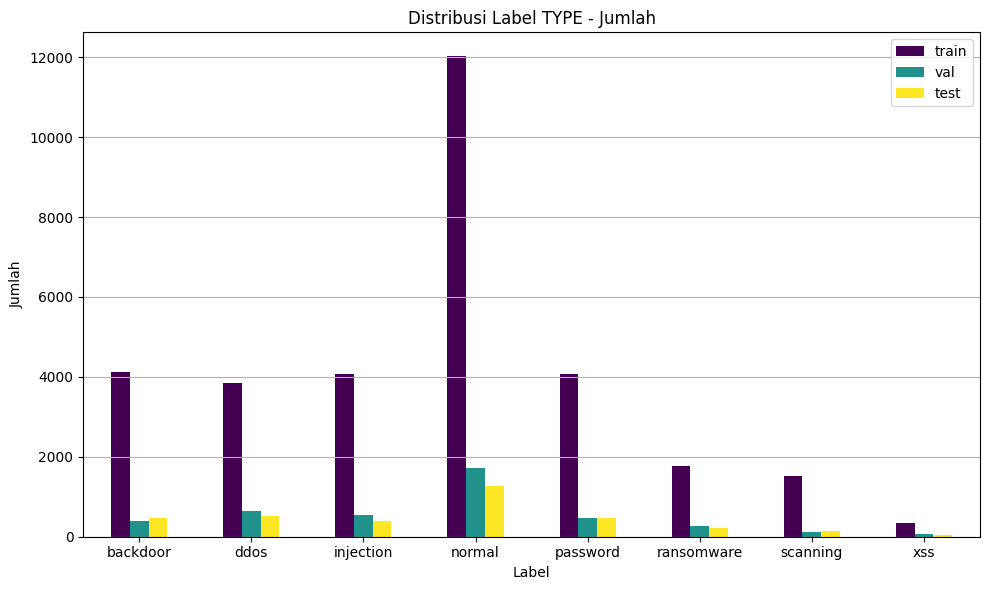

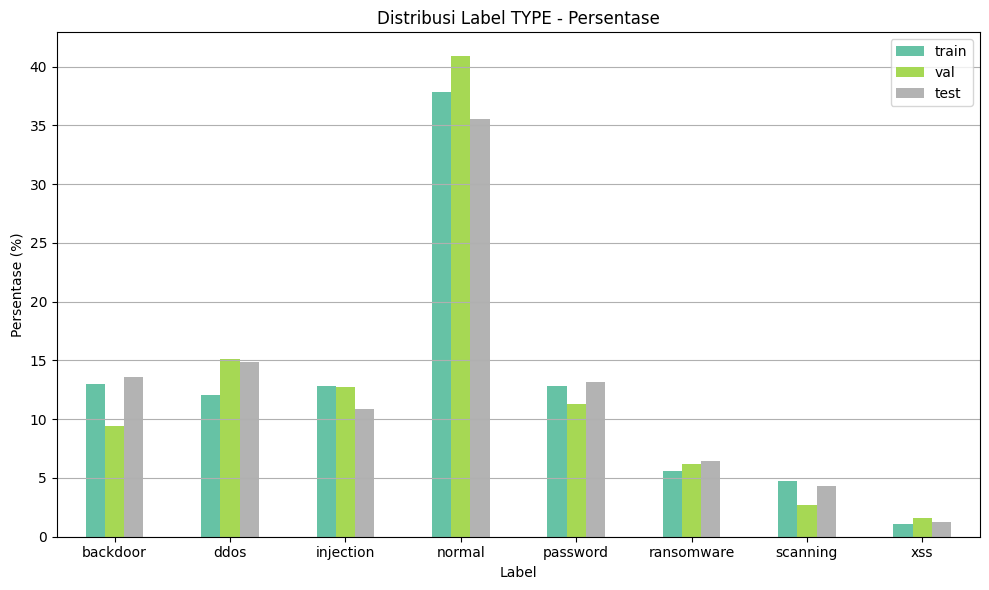

In [13]:
show_label_distribution(y_train_best, y_val_best, y_test_best, label_name='type')

In [14]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
# X_imputed_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_imputed_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
# X_imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# print(f"Features shape train after imputation: {X_imputed_train.shape}")
# print(f"Features shape val after imputation: {X_imputed_val.shape}")
# print(f"Features shape test after imputation: {X_imputed_test.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_val_scaled = scaler.transform(X_val_best)
X_test_scaled = scaler.transform(X_test_best)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_train_scaled.shape}")
print(f"Scaled features val shape: {X_val_scaled.shape}")
print(f"Scaled features test shape: {X_test_scaled.shape}")



# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_best)
y_val_encoded = le.transform(y_val_best)
y_test_encoded = le.transform(y_test_best)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(le, f)

print(f"Target classes: {le.classes_}")
print(f"Target train shape: {y_train_encoded.shape}")
print(f"Target val shape: {y_val_encoded.shape}")
print(f"Target test shape: {y_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Data scaling completed!
Scaled features train shape: (31744, 25)
Scaled features val shape: (4203, 25)
Scaled features test shape: (3541, 25)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target train shape: (31744,)
Target val shape: (4203,)
Target test shape: (3541,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [15]:
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [16]:
print(X_train_scaled.shape)
print('\n',X_train_scaled[:5])
print('\n',X_val_scaled.shape)
print('\n',X_val_scaled[:5])
print('\n',X_test_scaled.shape)
print('\n',X_test_scaled[:5])
print('\n',y_train_encoded.shape)
print('\n',y_train_encoded[:10])
print('\n',y_val_encoded.shape)
print('\n',y_val_encoded[:10])
print('\n',y_test_encoded.shape)
print('\n',y_test_encoded[:10])
print('\n',y_train_cat.shape)
print('\n',y_train_cat[:10])
print('\n',y_val_cat.shape)
print('\n',y_val_cat[:10])
print('\n',y_test_cat.shape)
print('\n',y_test_cat[:10])

(31744, 25)

 [[1.00000000e+00 5.21739130e-01 6.10169492e-01 8.81355932e-01
  1.00000000e+00 1.00000000e+00 5.00000000e-01 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 1.11111111e-01
  0.00000000e+00 1.00000000e+00 0.00000000e+00 1.11111111e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 5.21739130e-01 6.10169492e-01 8.98305085e-01
  1.00000000e+00 1.00000000e+00 5.00000000e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.99864787e-07 1.00000000e+00
  1.00000000e+00 5.00000000e-01 1.00000000e+00 1.11111111e-01
  1.00000000e+00 5.00000000e-01 1.00000000e+00 1.11111111e-01
  1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [0.00000000e+00 5.21739130e-01 6.10169492e-01 9.15254237e-01
  1.00000000e+00 1.00000000e+00 5.00000000e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.99864787e-07 0.00000000e+00
  0.00000000e+00 3.3

In [17]:
train_labels = np.argmax(y_train_cat, axis=1)
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
minority_classes = [cls for cls, count in class_counts.items() if count / total_samples < 0.1]
print("Minority classes:", minority_classes)

Minority classes: [6, 7, 5]


In [18]:
# ================================
# SELEKSI FITUR GA
# ================================

# ========================================
# =========== PARAMETER & INPUT ==========
# ========================================
POP_SIZE = 20
N_GENERATIONS = 15
MUTATION_RATE = 0.2
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X_train_scaled.shape[1]
N_CLASSES = y_train_cat.shape[1]

y_train_labels = np.argmax(y_train_cat, axis=1)
y_val_labels = np.argmax(y_val_cat, axis=1)

# =============================
# === CLASS WEIGHT OTOMATIS ===
# =============================
class_weight_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = {i: w for i, w in enumerate(class_weight_values)}
print("Class weights:", class_weights)

# ========================================
# ========== MODEL LSTM SEDERHANA ========
# ========================================
def create_lstm_model(input_shape, n_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

# ========================
# === FITNESS FUNCTION ===
# ========================
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]

    # Subset data
    X_train_sub = X_train_scaled[:, selected_features]
    X_val_sub = X_val_scaled[:, selected_features]

    # Reshape untuk LSTM
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    # Buat model dan latih
    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=N_CLASSES)
    model.fit(X_train_sub, y_train_cat, epochs=3, batch_size=64, verbose=0, class_weight=class_weights)

    # Evaluasi
    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)

    # Hitung F1 Macro dengan bobot kelas
    f1_per_class = f1_score(y_val_labels, y_pred, average=None)
    weights = np.array([class_weights.get(i, 1.0) for i in range(len(f1_per_class))])
    weighted_f1 = np.average(f1_per_class, weights=weights)

    return weighted_f1,

# ===========================
# === TOOLS UNTUK GA ===
# ===========================
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# ==========================
# === MAIN LOOP GA ===
# ==========================
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    f1s = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(f1s):.4f} | Avg fitness: {np.mean(f1s):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        mutate(c1)
        mutate(c2)
        new_population.extend([c1, c2])

    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# ===========================
# === OUTPUT AKHIR GA ===
# ===========================
f1s = [fit[0] for fit in fitnesses]
best_idx = np.argmax(f1s)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n=== HASIL SELEKSI FITUR GA DENGAN CLASS WEIGHT ===")
print("Indeks Fitur Terpilih:", selected_features)
print("Jumlah Fitur Terpilih:", len(selected_features))
print("Best Fitness (Weighted F1 Macro): {:.4f}".format(f1s[best_idx]))

Class weights: {0: 0.9624060150375939, 1: 1.0336025006512113, 2: 0.9732646553838606, 3: 0.33006155381800034, 4: 0.9773399014778326, 5: 2.23297692740574, 6: 2.6312997347480107, 7: 11.7396449704142}

Generation 1/15
 Best fitness: 0.9245 | Avg fitness: 0.7545

Generation 2/15
 Best fitness: 0.9290 | Avg fitness: 0.7969

Generation 3/15
 Best fitness: 0.9286 | Avg fitness: 0.7391

Generation 4/15
 Best fitness: 0.9291 | Avg fitness: 0.7962

Generation 5/15
 Best fitness: 0.9277 | Avg fitness: 0.7933

Generation 6/15
 Best fitness: 0.9265 | Avg fitness: 0.7727

Generation 7/15
 Best fitness: 0.9265 | Avg fitness: 0.8395

Generation 8/15
 Best fitness: 0.9283 | Avg fitness: 0.7786

Generation 9/15
 Best fitness: 0.9277 | Avg fitness: 0.7906

Generation 10/15
 Best fitness: 0.9265 | Avg fitness: 0.8407

Generation 11/15
 Best fitness: 0.9269 | Avg fitness: 0.8641

Generation 12/15
 Best fitness: 0.9271 | Avg fitness: 0.8362

Generation 13/15
 Best fitness: 0.9292 | Avg fitness: 0.8247

Gener

In [19]:
feature_names = X_all.columns.tolist()

selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['hour', 'minute', 'second', 'day_of_week', 'hour_sin', 'is_night', 'time_diff', 'light_sum_10', 'light_entropy', 'light_dom_freq', 'motion_lag1']


In [20]:
X_train_selected = pd.DataFrame(X_train_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_train_selected.shape)
print(X_train_selected.info())
print(X_train_selected.head())

(31744, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31744 entries, 0 to 31743
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hour            31744 non-null  float64
 1   minute          31744 non-null  float64
 2   second          31744 non-null  float64
 3   day_of_week     31744 non-null  float64
 4   hour_sin        31744 non-null  float64
 5   is_night        31744 non-null  float64
 6   time_diff       31744 non-null  float64
 7   light_sum_10    31744 non-null  float64
 8   light_entropy   31744 non-null  float64
 9   light_dom_freq  31744 non-null  float64
 10  motion_lag1     31744 non-null  float64
dtypes: float64(11)
memory usage: 2.7 MB
None
       hour    minute    second  day_of_week  hour_sin  is_night  \
0  0.521739  0.610169  0.881356          1.0       0.5       0.0   
1  0.521739  0.610169  0.898305          1.0       0.5       0.0   
2  0.521739  0.610169  0.915254          1.0

In [21]:
X_val_selected = pd.DataFrame(X_val_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_val_selected.shape)
print(X_val_selected.info())

(4203, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4203 entries, 0 to 4202
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hour            4203 non-null   float64
 1   minute          4203 non-null   float64
 2   second          4203 non-null   float64
 3   day_of_week     4203 non-null   float64
 4   hour_sin        4203 non-null   float64
 5   is_night        4203 non-null   float64
 6   time_diff       4203 non-null   float64
 7   light_sum_10    4203 non-null   float64
 8   light_entropy   4203 non-null   float64
 9   light_dom_freq  4203 non-null   float64
 10  motion_lag1     4203 non-null   float64
dtypes: float64(11)
memory usage: 361.3 KB
None


In [22]:
X_test_selected = pd.DataFrame(X_test_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_test_selected.shape)
print(X_test_selected.info())

(3541, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3541 entries, 0 to 3540
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hour            3541 non-null   float64
 1   minute          3541 non-null   float64
 2   second          3541 non-null   float64
 3   day_of_week     3541 non-null   float64
 4   hour_sin        3541 non-null   float64
 5   is_night        3541 non-null   float64
 6   time_diff       3541 non-null   float64
 7   light_sum_10    3541 non-null   float64
 8   light_entropy   3541 non-null   float64
 9   light_dom_freq  3541 non-null   float64
 10  motion_lag1     3541 non-null   float64
dtypes: float64(11)
memory usage: 304.4 KB
None



CORRELATION ANALYSIS


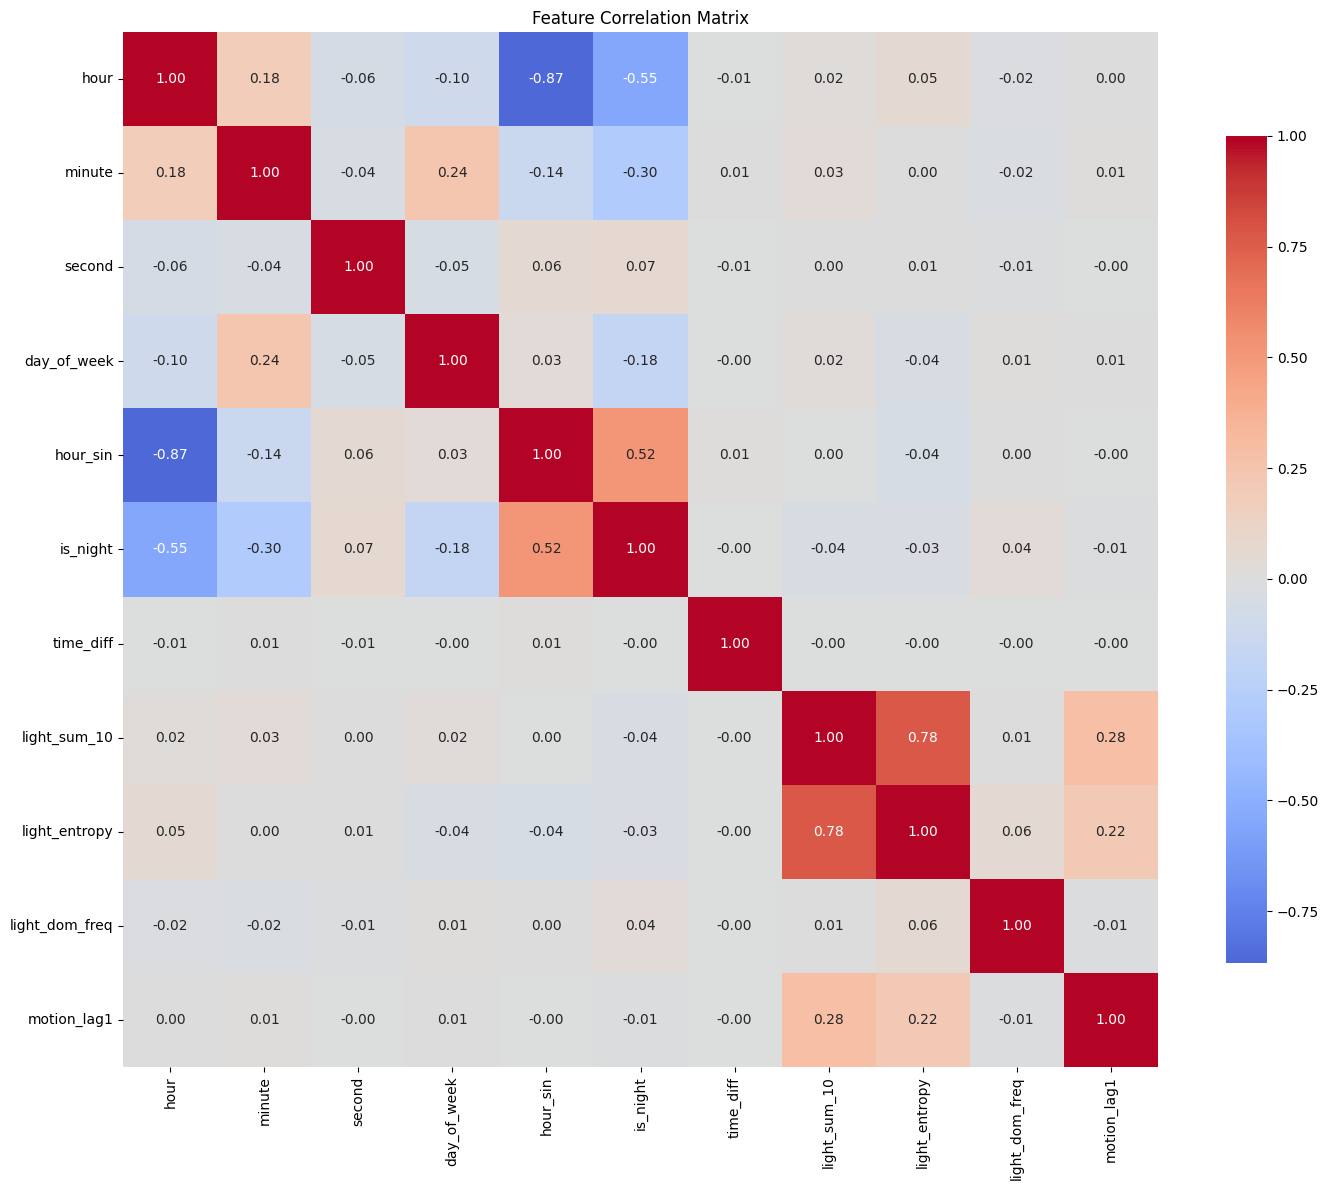

In [23]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_train_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

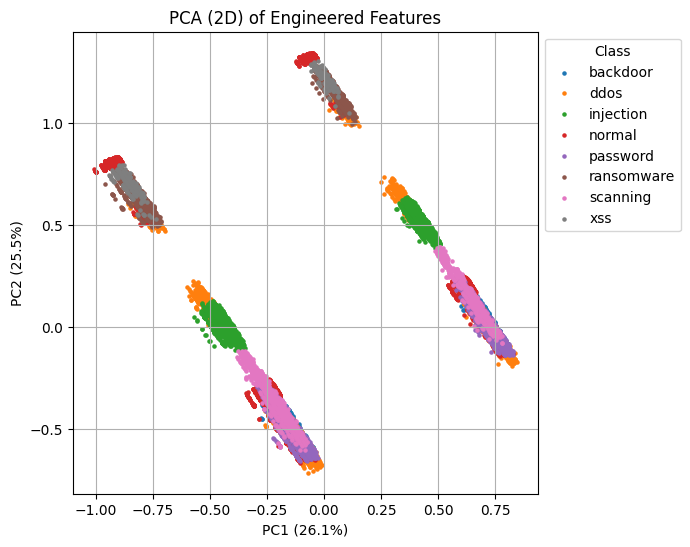

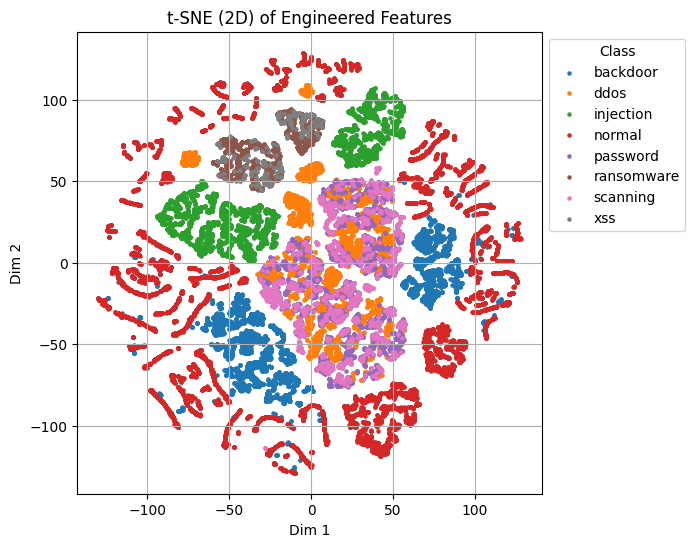

In [24]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [25]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_train_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y_train_best
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_train_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_train_best

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [26]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_train_selected, y_train_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_train_selected)
df_final['type'] = np.array(y_train_encoded)

csv_path = os.path.join(artifacts_dir, 'data_train_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [27]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_val_selected, y_val_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_val_selected)
df_final['type'] = np.array(y_val_encoded)

csv_path = os.path.join(artifacts_dir, 'data_val_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [28]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_test_selected, y_test_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_test_selected)
df_final['type'] = np.array(y_test_encoded)

csv_path = os.path.join(artifacts_dir, 'data_test_preprocessing.csv')
df_final.to_csv(csv_path, index=False)